# 利用卷积神经网络解决手写数字识别 

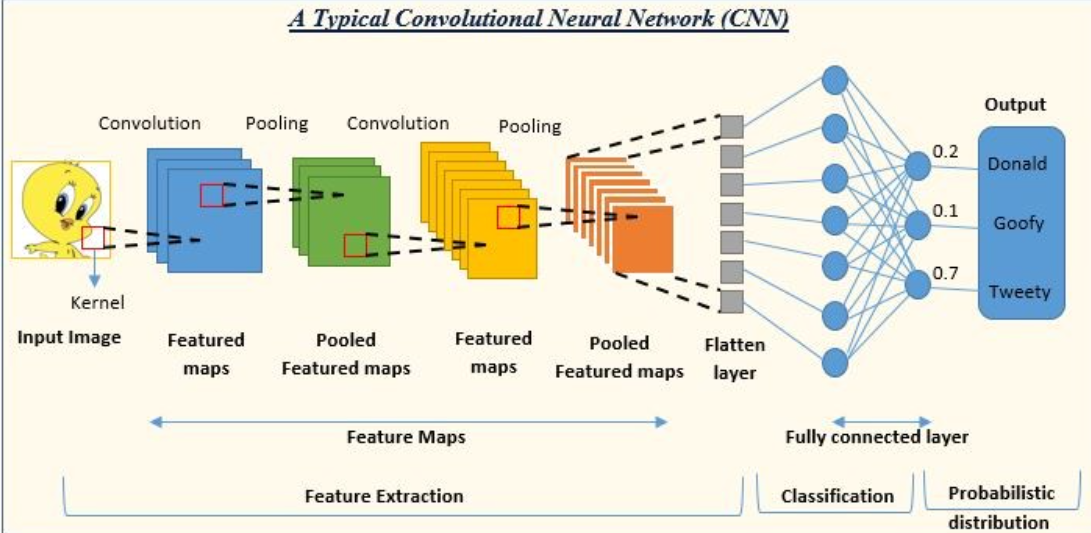

## 导包 

In [1]:
import torch 
from torch import nn 
import torch.nn.functional as F 
import numpy as np 
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

## 构建数据 

In [2]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(), #将读取的数据转换为张量
        # transforms.Normalize() #初学不建议
        #标准化到-1~1之间
       ]
)

### 加载datasets 

In [3]:
DS_Train = datasets.MNIST(
    '../00机器学习回顾/dataset/', #指定数据的下载位置 
    train=True, #声明是Train数据 
    transform=transformation, #要做的变换
    download=False, #是否下载,这里我已经下载了,就不浪费流量了
)

In [4]:
type(DS_Train)

torchvision.datasets.mnist.MNIST

In [5]:
DS_Test = datasets.MNIST(
    '../00机器学习回顾/dataset/', #指定数据的下载位置 
    train=False, #非Train数据集 
    transform=transformation, #要做的变换
    download=False, #是否下载
)

### 用dataloader加载 

In [6]:
DL_train = DataLoader(DS_Train,batch_size=64,shuffle=True)
DL_test = DataLoader(DS_Test,batch_size=256,shuffle=False)
#测试集并不需要反向传播,所以占用资源比较小,所以可以提升测试集
# 的batchsize

## 创建模型 

使用卷积神经网络不用一开始就展平

### conv2d 

`Conv2d` 是二维卷积层的实现，广泛用于处理如图像这样的二维数据。在深度学习框架中（例如PyTorch），`Conv2d`函数或类允许定义和应用二维卷积操作。以下是 `Conv2d` 的主要参数简述：

1. **in_channels**：输入数据的通道数。对于RGB图像，这个值为3；对于灰度图像，该值为1。

2. **out_channels**：卷积核的数量，也即输出特征图的通道数。每个卷积核生成一个特征图，所以这个参数决定了输出的深度。

3. **kernel_size**：卷积核的大小。可以是一个整数（如果高度和宽度相同）或者一个包含两个整数的元组（分别指定高度和宽度）。

4. **stride**：卷积核每次滑动的步长，默认值为1。可以是一个整数或者一个包含两个整数的元组，分别对应于垂直和水平方向上的步长。

5. **padding**：控制如何对输入边界进行填充。可以是整数、元组或字符串（如 'valid' 或 'same'）。默认情况下是0，意味着不进行填充。当设置为 'same' 时，会自动计算需要的填充量以保证输出的空间尺寸与输入相同（假设 stride=1）。

6. **dilation**：卷积核元素之间的间距，用于扩展卷积核的感受野而不增加参数数量。默认值为1，意味着没有扩张。可以是一个整数或者一个包含两个整数的元组。

7. **groups**：控制输入和输出之间的连接方式。默认值为1，表示所有输入通道都被用来计算每个输出通道。如果设置为 `in_channels`，则变为深度可分离卷积（Depthwise Separable Convolution）。

8. **bias**：布尔值，指示是否在输出中添加偏置项。默认为True。

9. **padding_mode**：填充模式，可以选择 'zeros', 'reflect', 'replicate' 或 'circular'。默认是 'zeros'。

这些参数共同决定了卷积层的具体行为和它如何转换输入数据。通过调整这些参数，可以根据特定任务的需求定制卷积层的行为。例如，改变 `kernel_size` 可以影响模型捕捉不同尺度特征的能力，而调整 `stride` 和 `padding` 则可以控制输出特征图的尺寸。

### 定义模型 

#### 池化

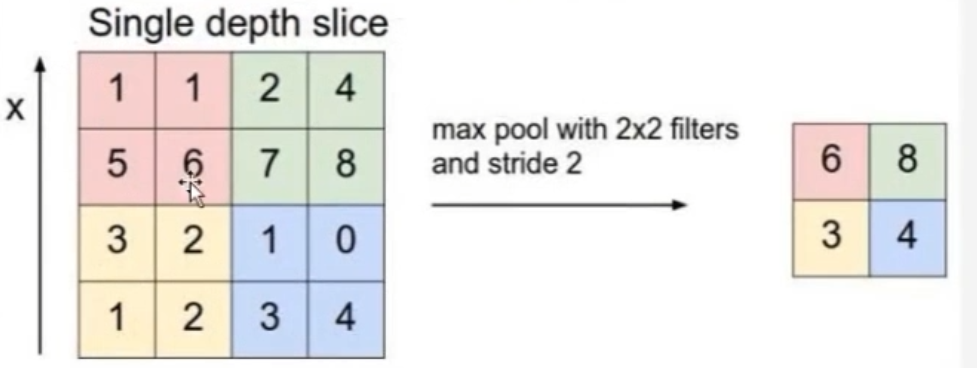

In [ ]:
 class Model(nn.Module): 
     def __init__(self):
         super().__init__()  
         #初始化卷积层  
         self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5) #使用6个卷积核，卷积核大小为5*5
         #设置池化层
         self.pool = nn.MaxPool2d(kernel_size=(2,2))  #设置池化核为2*2 ,也就是四个格子里选出一个,原来的是28*28的,然后会变成14*14的
         #设置第二个卷积层
         self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)  #第一个卷积层是6个输出channels,所以第二个卷积层的输入channel大小是第一个卷积层的输入大小
         
         #设置全连接层
         self.liner_1 = nn.Linear(6*16*5,256) #linear的大小是最后一个卷积层的像素展开的大小
         self.liner_2 = nn.Linear(256,10) #0-9所以是10分类
     def forward(self,input): 
         x = self.conv1(input) #输入的是MNIST中的28*28像素的图片
         x = F.relu(x)  #激活
         x = self.pool(x) #调用卷积核进行池化操作,将28*28的划分区块为14*14的特征图
         x = self.conv2(x) #再次进行卷积操作
         x = F.relu(x) 
         x = self.pool(x) #这里再次使用池化层,将其转化为7*7的

         print(x.size())

         x = x.view(-1,16*5*5) #将其展平
         x = F.relu(self.liner_1(x))  
         x = F.relu(self.liner_2(x))
         x = F.relu(self.liner_3(x))
         return x

你的代码和注释确实存在一些**逻辑错误和理解偏差**，尤其是在计算全连接层的输入尺寸、展平操作的对象以及网络结构的设计方面。下面我会：

1. **指出你代码中的主要问题**
2. **解释每个关键步骤的正确含义**
3. **给出修改后的完整代码示例**

---

## 🔍 一、你代码中存在的主要问题

### ✅ 问题1：`self.liner_1` 的输入维度不正确

你写的是：
```python
self.liner_1 = nn.Linear(6*16*5, 256)
```

但实际上经过两次卷积 + 池化后，输出的特征图大小不是 `5x5`，而是 `4x4`（见下文详细推导）。

所以这里应该是：
```python
nn.Linear(16 * 5 * 5, 256) ❌ 错误
nn.Linear(16 * 4 * 4, 256) ✅ 正确
```

### ✅ 问题2：你在 forward 中展平了错误的变量

你写的是：
```python
x = input.view(-1, 16*5*5)  # 错误！应该展平 x 而不是 input
```

但此时 `x` 才是经过两个卷积层和池化层之后的输出张量。你却重新用了原始的 `input`，这会导致模型无法正常工作。

### ✅ 问题3：`liner_3` 并未定义

你在最后调用了 `liner_3(x)`，但没有在 `__init__` 中定义它。

### ✅ 问题4：缺少激活函数与分类层的合理性

最后一层输出应该是 `logits` 或者接上 `softmax`，但你用的是 `F.relu()`，不太合理。

---

## 🧮 二、前向传播中张量尺寸变化详解（以 MNIST 输入为例）

假设输入为 `batch_size x 1 x 28 x 28`（如 MNIST 图像）

| 层 | 输入形状 | 操作 | 输出形状 |
|----|----------|------|-----------|
| Conv1 (1→6, kernel=5) | `(B, 1, 28, 28)` | 卷积 | `(B, 6, 24, 24)` |
| ReLU | - | 激活 | `(B, 6, 24, 24)` |
| MaxPool (2x2) | - | 池化 | `(B, 6, 12, 12)` |
| Conv2 (6→16, kernel=5) | `(B, 6, 12, 12)` | 卷积 | `(B, 16, 8, 8)` |
| ReLU | - | 激活 | `(B, 16, 8, 8)` |
| MaxPool (2x2) | - | 池化 | `(B, 16, 4, 4)` |
| Flatten | `(B, 16, 4, 4)` | 展平 | `(B, 256)` |
| Linear(256 → 120) | - | 全连接 | `(B, 120)` |
| Linear(120 → 84) | - | 全连接 | `(B, 84)` |
| Linear(84 → 10) | - | 全连接 | `(B, 10)` |

> 注：这是典型的 LeNet 架构风格。

---

## ✅ 三、修正后的完整代码（PyTorch 风格）

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 第一个卷积层：输入通道1（灰度图），输出通道6，卷积核5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        
        # 最大池化层，核大小2x2，步长2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二个卷积层：输入通道6，输出通道16，卷积核5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # 全连接层
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 展平后的尺寸是 16x4x4
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 输出10类（例如MNIST数字）

    def forward(self, x):
        # 第一层卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv1(x)))  # [B, 1, 28, 28] -> [B, 6, 12, 12]
        
        # 第二层卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv2(x)))  # [B, 6, 12, 12] -> [B, 16, 4, 4]

        # 展平为一维向量
        x = x.view(-1, 16 * 4 * 4)  # [B, 16, 4, 4] -> [B, 256]

        # 全连接层
        x = F.relu(self.fc1(x))     # [B, 256] -> [B, 120]
        x = F.relu(self.fc2(x))     # [B, 120] -> [B, 84]
        x = self.fc3(x)             # [B, 84] -> [B, 10]

        return x
```

---

## 📝 四、建议的学习资源

- PyTorch 官方教程：https://pytorch.org/tutorials/
- 经典 CNN 架构：LeNet、AlexNet、VGG、ResNet
- 使用 `torchsummary.summary(model, input_size=(C, H, W))` 可视化网络结构和参数

---

## ✅ 总结

| 原始问题 | 修正建议 |
|----------|-----------|
| 线性层输入尺寸错误 | 根据实际输出展平尺寸设置 |
| 展平使用了 input 而非 x | 应该对最终特征图 x 进行 view 操作 |
| 缺少 liner_3 | 添加对应的线性层 |
| 最后一层用了 ReLU | 分类任务应直接输出 logits，或加 softmax |

如果你正在学习 CNN 或 PyTorch，这段代码可以作为你实现 LeNet 类型图像分类器的基础模板。如果你想进一步扩展模型，比如加入 BatchNorm、Dropout、残差连接等，也可以告诉我，我可以帮你升级架构 😊

从形状 `(B, 1, 28, 28)` 变为 `(B, 6, 24, 24)` 的过程涉及到了卷积操作。这里的变化主要由以下几个因素决定：输入尺寸、卷积核大小（`kernel_size`）、是否使用填充（`padding`）以及步长（`stride`）。在你给出的例子中，没有特别提到 `padding` 和 `stride` 的值，默认情况下它们分别是 `0`（即不填充）和 `1`（即每次移动一个像素）。

### 计算输出尺寸的公式

对于二维卷积层（`Conv2d`），如果输入尺寸为 `(height, width)`，卷积核大小为 `k`，步长为 `s`，填充为 `p`，则输出尺寸可按照以下公式计算：

```
output_height = (input_height - kernel_size + 2 * padding) / stride + 1
output_width = (input_width - kernel_size + 2 * padding) / stride + 1
```

注意，这里的除法结果需要向下取整（即应用了地板除法），并且所有参数都假设为正方形（即高度和宽度相同的情况）。如果不是正方形，则需分别计算高度和宽度方向的结果。

### 应用到你的例子

给定：
- 输入尺寸为 `(28, 28)`
- 卷积核大小 `kernel_size=5`
- 默认步长 `stride=1`
- 默认填充 `padding=0`

将这些值代入上述公式中：

```
output_height = (28 - 5 + 2 * 0) / 1 + 1 = 24
output_width = (28 - 5 + 2 * 0) / 1 + 1 = 24
```

因此，输出尺寸变为 `(24, 24)`。加上批次维度 `B` 和通道数 `6`（因为你在第一个卷积层中设置了 `out_channels=6`），最终输出尺寸就是 `(B, 6, 24, 24)`。

### 总结

- **输入**：`(B, 1, 28, 28)`
- **经过第一个卷积层后**：由于使用了 `kernel_size=5`，无填充（`padding=0`），步长为 `1`，输出尺寸计算为 `(B, 6, 24, 24)`。

这个过程中，虽然输入图像的尺寸减小了（从 28x28 减少到 24x24），但同时增加了特征图的数量（从 1 增加到 6），意味着模型开始学习并识别输入数据中的更多特征。如果你希望保持或增加输出尺寸，可以考虑调整 `padding` 参数或者选择不同的 `stride`。例如，使用适当的填充（如 `padding=2`），即使卷积核大小不变，也可以保持输出尺寸与输入尺寸相同。

## 修正 

In [7]:

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 第一个卷积层：输入通道1（灰度图），输出通道6，卷积核5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        
        # 最大池化层，核大小2x2，步长2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 第二个卷积层：输入通道6，输出通道16，卷积核5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # 全连接层
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 展平后的尺寸是 16x4x4
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 输出10类（例如MNIST数字）

    def forward(self, x):
        # 第一层卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv1(x)))  # [B, 1, 28, 28] -> [B, 6, 12, 12]
        
        # 第二层卷积 + 激活 + 池化
        x = self.pool(F.relu(self.conv2(x)))  # [B, 6, 12, 12] -> [B, 16, 4, 4]

        # 展平为一维向量
        x = x.view(-1, 16 * 4 * 4)  # [B, 16, 4, 4] -> [B, 256]

        # 全连接层
        x = F.relu(self.fc1(x))     # [B, 256] -> [B, 120]
        x = F.relu(self.fc2(x))     # [B, 120] -> [B, 84]
        x = self.fc3(x)             # [B, 84] -> [B, 10]

        return x

## 定义训练函数 

In [8]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    
   
  
    Model_m.train()  # 设置为训练模式
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了灯饰可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval()
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


### 创建模型

In [9]:
model = Model() 

In [10]:
model

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 创建损失函数和优化函数 

In [11]:
lr = 0.001 
lossfn = nn.CrossEntropyLoss()  
optm = torch.optim.Adam(model.parameters(),lr=lr)

### 开训 

In [13]:
epochs = 10 
train_loss = [] 
train_acc = [] 
test_loss =[] 
test_acc = [] 
for epoch in range(epochs): 
        loss,acc,tst_loss,tst_acc = fit_gpu(DL_train,DL_test,model,epoch,optm,lossfn) 
        train_loss.append(loss)
        train_acc.append(acc)
        test_loss.append(tst_loss)
        test_acc.append(tst_acc)

epoch:0 | loss:0.004 | acc:0.912 | tstloss:0.000 | tstacc:0.969
epoch:1 | loss:0.001 | acc:0.973 | tstloss:0.000 | tstacc:0.978
epoch:2 | loss:0.001 | acc:0.980 | tstloss:0.000 | tstacc:0.985
epoch:3 | loss:0.001 | acc:0.985 | tstloss:0.000 | tstacc:0.984
epoch:4 | loss:0.001 | acc:0.987 | tstloss:0.000 | tstacc:0.985
epoch:5 | loss:0.001 | acc:0.989 | tstloss:0.000 | tstacc:0.989
epoch:6 | loss:0.000 | acc:0.991 | tstloss:0.000 | tstacc:0.987
epoch:7 | loss:0.000 | acc:0.991 | tstloss:0.000 | tstacc:0.990
epoch:8 | loss:0.000 | acc:0.993 | tstloss:0.000 | tstacc:0.989
epoch:9 | loss:0.000 | acc:0.993 | tstloss:0.000 | tstacc:0.988


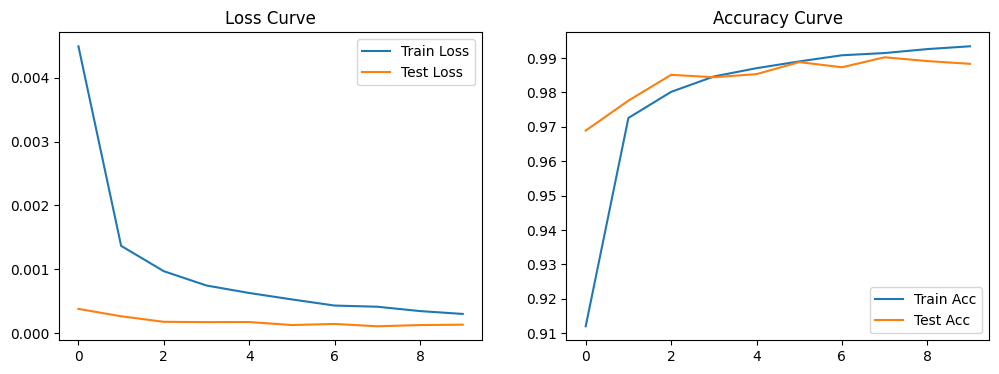

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(test_acc, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

In [16]:
import pickle as pkl 
with open('models/cnn01.pkl','wb') as f: 
    pkl.dump(model,f)